In my last project, 'Who Owns What? Fayetteville', I looked at geospatial data containing information for land parcels in Fayetteville, AR. In my analysis, I worked to find patterns that indicate a promising (or not-so-promising) future for aspiring landowners in the city. Overall, the results left me optimistic in my dream of ownership, but I still wondered whether there would be any patterns in land value data as well. I wanted to know, in dollar amounts: Who owns how much?

Picking up where 'Who Owns What?' left off, I'll be looking at parcel assessor value data for Fayetteville, AR, as provided by the Washington County Assessor's Office. <a href='https://www.washingtoncountyar.gov/government/departments-a-e/assessor/ftp-instructions'>Data</a>

First we import the goods:

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

Load the data, selecting the info we want to work with:

In [46]:
wash = gpd.read_file('Fayetteville.gdb')

In [47]:
parcels = gpd.read_file('Parcel.gdb')
parcels = parcels.drop_duplicates(subset='PIN')
parcels = parcels[['PIN', 'geometry']]
wash = wash[['PIN', 'CALC_ACRES', 'RPID', 'ow_name', 'ow_add1', 'ow_city', 'ow_zip', 'assess_val', 'imp_val', 'land_val', 'total_val']]
fay = parcels.merge(wash, on="PIN")

In [54]:
# Save for the public good
fay.to_pickle('./fayAss.pkl')
fay.to_csv('./fayAss.csv')

In [3]:
fay = pd.read_pickle('fayAss.pkl')

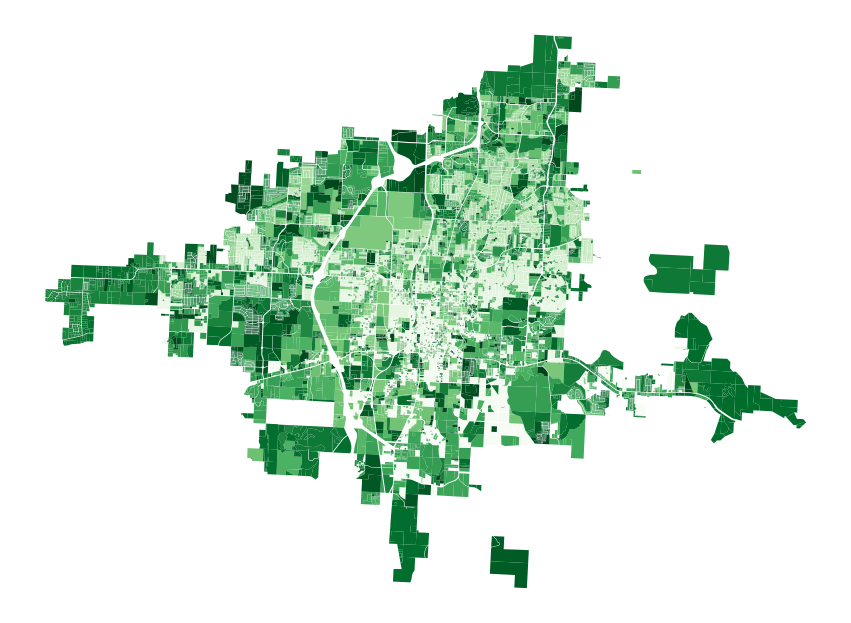

In [3]:
fay.plot(cmap='Greens', figsize=(15,15)).set_axis_off()

Perfect! A familiar figure.

I'll cut straight to it... who owns the most, in terms of dollars?

In [4]:
n = 10
grouped = fay.groupby(by="ow_name").sum()
topn = grouped.sort_values('total_val', ascending = False).head(n)
topn = topn['total_val']
topn

ow_name
MATHIAS SHOPPING CENTERS INC             62894227.0
FAYETTEVILLE STUDENT HOUSING DST         62408750.0
SSSST 376 W WATSON ST LLC                53285000.0
CARDINAL GROUP FAYETTEVILLE I            51673400.0
COLLEGE PARK FRISCO HOLDINGS LLC         50555763.0
AR-UA HOLDINGS LLC                       44662800.0
UNIVERSITY HOUSE FAYETTEVILLE            44200000.0
LINKS AT FAYETTEVILLE                    43772400.0
SOUTH GARLAND BOULEVARD ASSOCIATES LP    43624000.0
WAL-MART REAL ESTATE BUSINESS TRUST      43113400.0
Name: total_val, dtype: float64

According to the data, Mathias Shopping Centers Inc. takes the lead with roughly ~$63,000,000 in property in Fayetteville, followed closely by Fayetteville Student Housing dst.

However, we saw in 'Who Owns What?' that the City of Fayetteville and the University of Arkansas owned -- by a lot -- the most by area and number of parcels. So why don't they show up in the top 'n' owners by value?
If we look at their values specifically...

In [6]:
uaVal = grouped[grouped.index == 'UNIVERSITY OF ARKANSAS'][['CALC_ACRES', 'assess_val', 'land_val', 'total_val']]
cityVal = grouped[grouped.index == 'CITY OF FAYETTEVILLE'][['CALC_ACRES', 'assess_val', 'land_val', 'total_val']]

print(uaVal)
print(cityVal)

                         CALC_ACRES  assess_val  land_val  total_val
ow_name                                                             
UNIVERSITY OF ARKANSAS  1465.604547         0.0       0.0        0.0
                       CALC_ACRES  assess_val   land_val  total_val
ow_name                                                            
CITY OF FAYETTEVILLE  5625.352237    689907.0  3055250.0  3997900.0


We see that the University data is (for some reason) not complete. It does not contain value data at all. The City Of Fayetteville has values, but they seem suspiciously low given what we know about the city's other ownership stats. This is somewhat concerning for any analysis. Can we expect gaps across the rest of the data? We can check all records for completeness:

In [101]:
# check all city parcels for null or 0 entries
mVals = fay[(pd.isnull(fay['total_val'])) | (fay['total_val'] == 0)]
print(mVals['ow_name'].value_counts())
print('Total incomplete parcels: ' + str(mVals['ow_name'].value_counts().sum()))


CITY OF FAYETTEVILLE                    576
UNIVERSITY OF ARKANSAS                  494
FAYETTEVILLE SCHOOL DISTRICT # 1         69
UNITED STATES OF AMERICA                 36
PARADIGM DEVELOPMENT ENTERPRISES INC     32
                                       ... 
CEMETERY AKA THARP CEMETERY               1
PATHWAY BAPTIST CHURCH                    1
SANG AVENUE BAPTIST CHURCH                1
CALVARY BAPTIST CHURCH                    1
HOSKINS, TRACY & CELESTE                  1
Name: ow_name, Length: 401, dtype: int64
Total incomplete parcels: 2036


And we see that 576 of the city's 626 parcel records from this dataset do not contain valid values. In fact, 401 unique owners in the data are tied to at least one parcel which does not have valid total values. This amounts to 2036 parcels in our data which are incomplete. We'll have to keep this in mind from here on.

We can get an idea of where some of the highest-value parcels are:

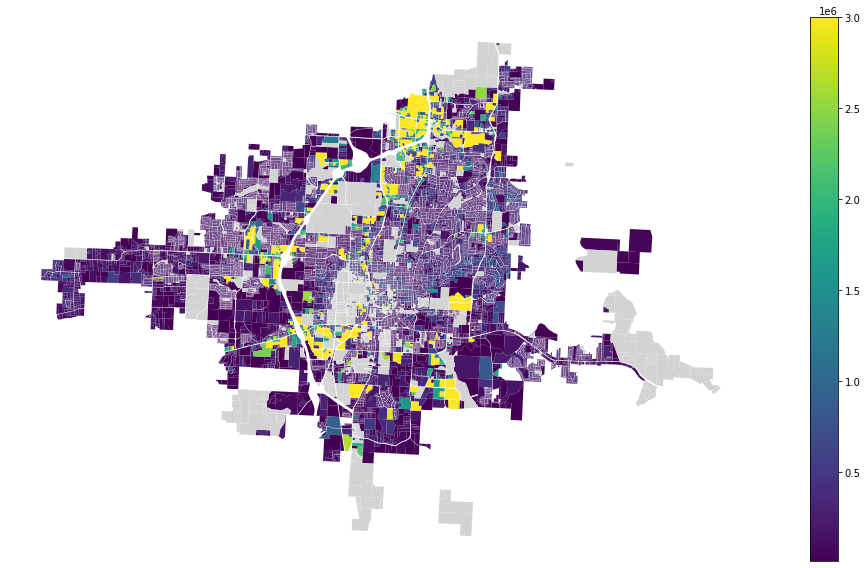

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
fay.plot(column='total_val', ax=ax, legend=True, vmin=10000, vmax=3000000, missing_kwds={"color": "lightgrey"}).set_axis_off()

And we can also plot value-per-acre, which may show a more descriptive concentration of value.

Text(0.5, 1.0, 'Total Value per Acre, Fayetteville AR')

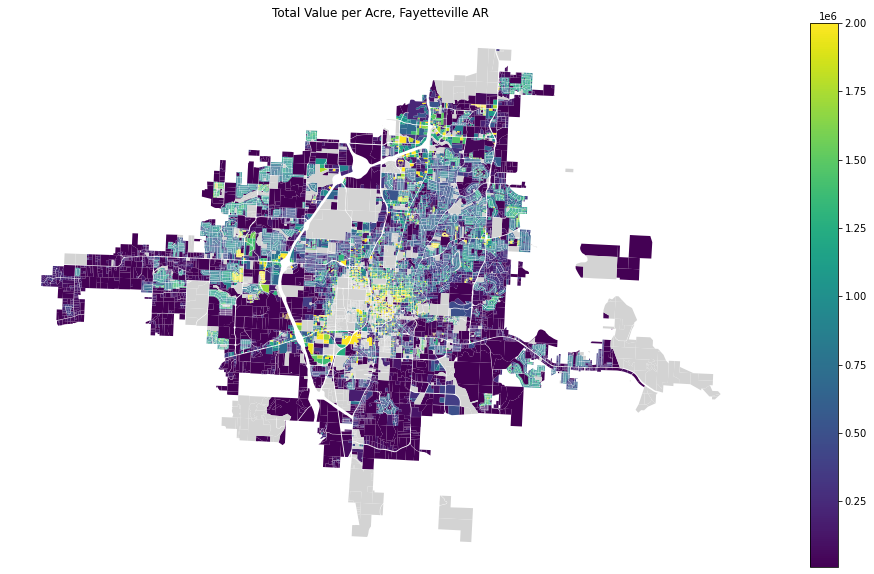

In [25]:
# Create value-per-acre data
fay['total_val_per_acre'] = fay['total_val'] / fay['CALC_ACRES']
fig, ax = plt.subplots(1, 1, figsize=(20,10))
fay.plot(column='total_val_per_acre', ax=ax, legend=True, vmin=10000, vmax=2000000, missing_kwds={"color": "lightgrey"}).set_axis_off()
ax.set_title('Total Value per Acre, Fayetteville AR')

So we can see, pretty predictably, that total property value per acre is (generally) higher in the downtown area and surrounding the University. There are also some hotspots uptown towards the mall and along Wedington.

But, it is possible that the value of some of these properties is mostly from property improvements (buildings) rather than the land itself. An aspiring home-builder may want to disregard the value of existing improvements. Would this look any different if we plotted land_val per acre?

Text(0.5, 1.0, 'Land Value per Acre, Fayetteville AR')

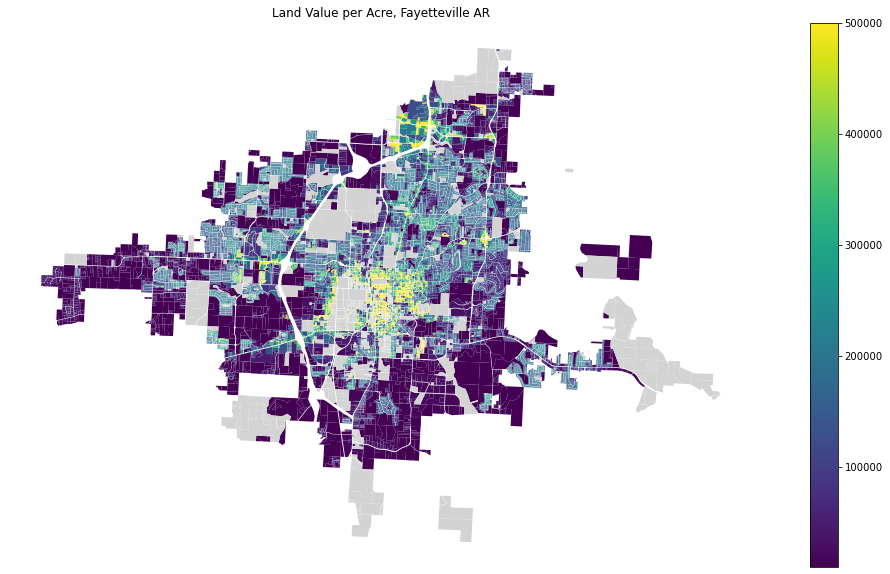

In [22]:
# Create land value-per-acre data
fay['land_val_per_acre'] = fay['land_val'] / fay['CALC_ACRES']
fig, ax = plt.subplots(1, 1, figsize=(20,10))
fay.plot(column='land_val_per_acre', ax=ax, legend=True, vmin=10000, vmax=500000, missing_kwds={"color": "lightgrey"}).set_axis_off()
ax.set_title('Land Value per Acre, Fayetteville AR')

As it turns out, our plots look mostly the same. There are some exceptions along MLK Blvd, where it appears that the buildings hold most of the value of the property. We could zoom in on MLK if we wanted:

(630000.0, 636000.0)

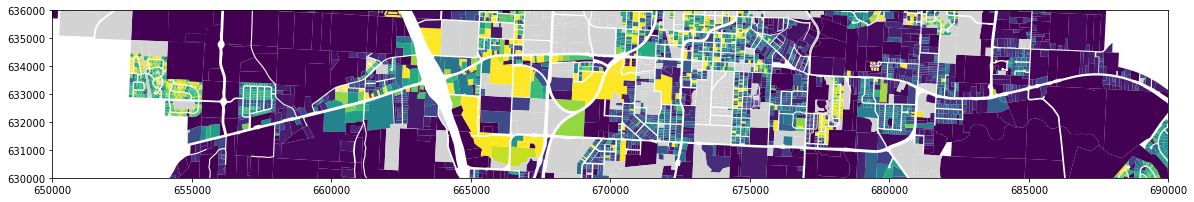

In [26]:
ax = fay.plot(column='total_val_per_acre', figsize=(20,20), vmin=10000, vmax=1500000, missing_kwds={"color": "lightgrey"})
ax.set_xlim(650000, 690000)
ax.set_ylim(630000, 636000)

Which all but confirms that the highest value properties in this area are apartment buildings/complexes. (The Vue, Hill Place, and Spectrum among those that appear brightly highlighted here, indicating high value)

In the end, it seems safe to say that given the data, an aspiring landowner has good prospects in Fayetteville. Land value appears to be mostly even, with a natural skew towards the city center. This, combined with the "Who Owns What?" data that suggests single-parcel ownership makes up most ownership in the city, allows me to remain optimistic in my dream of ownership.